In [372]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#  Packages & Imports

In [373]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import sklearn as skl
import warnings
import statsmodels.api as sm

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, validation_curve, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler, LabelEncoder, scale, MinMaxScaler, PolynomialFeatures, Imputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.feature_selection import RFE,SelectFromModel

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import make_classification

from xgboost import XGBClassifier 
from xgboost import plot_importance

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
import scipy.stats as stats

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')


In [374]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import math as m
import requests

In [375]:
#Load Datasets
train_data = pd.read_csv("training_set_values.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_data = pd.read_csv("test_set_values.csv")


In [376]:

# script for returning elevation from lat, long, based on open elevation data
# which in turn is based on SRTM
def get_elevation(lat, long):
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query).json()  # json object, various ways you can extract value
    # one approach is to use pandas json functionality:
    elevation = pd.io.json.json_normalize(r, 'results')['elevation'].values[0].astype(int)
    return elevation


In [377]:
lat = train_data.latitude[0]
long = train_data.longitude[0]

In [378]:
#get_elevation(lat,long)

In [379]:
#Join Labels with Train data
train_labels = train_labels.drop(columns='id')
train_data = train_data.join(train_labels)


In [380]:
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [381]:
test_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [382]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [383]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
id                       14850 non-null int64
amount_tsh               14850 non-null float64
date_recorded            14850 non-null object
funder                   13981 non-null object
gps_height               14850 non-null int64
installer                13973 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
wpt_name                 14850 non-null object
num_private              14850 non-null int64
basin                    14850 non-null object
subvillage               14751 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null int64
public_meeting           14029 non-null object
r

In [384]:
#Drop id and recorded from train dataset 
train_data= train_data.drop(columns=['id'])
train_data= train_data.drop(columns=['recorded_by'])


In [385]:
#Drop id and recorded from test dataset 
test_id= test_data['id']
test_data= test_data.drop(columns=['id'])
test_data= test_data.drop(columns=['recorded_by'])

# Data Preparation Proposals
Keeping all transformations in the same cell in an effort to make easy to recreate all steps for the Test set

In [386]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
scheme_management        55523 non-null object


In [387]:
for i in train_data.columns:
    inspect = train_data[i].value_counts()/len(train_data)
    print(inspect.head(5))

0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: amount_tsh, dtype: float64
2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: date_recorded, dtype: float64
Government Of Tanzania    0.152929
Danida                    0.052424
Hesawa                    0.037071
Rwssp                     0.023131
World Bank                0.022710
Name: funder, dtype: float64
 0     0.344074
-15    0.001010
-16    0.000926
-13    0.000926
-20    0.000875
Name: gps_height, dtype: float64
DWE           0.292963
Government    0.030724
RWE           0.020303
Commu         0.017845
DANIDA        0.017677
Name: installer, dtype: float64
0.000000     0.030505
37.540901    0.000034
33.010510    0.000034
39.093484    0.000034
32.972719    0.000034
Name: longitude, dtype: float64
-2.000000e-08    0.030505
-6.985842e+00    0.000034
-3.797579e+00    0.000034
-6.981884e+00    0.000034
-7.104625e+

In [393]:
#Impute amount TSH of regions 'Dodoma','Kagera','Mbeya','Tabora' with the mean of the whole pop
def amount_tsh_impute_regions(dataset):
    for i in range(0, len(dataset)):
        if dataset.amount_tsh[i] == 0:
            if dataset.region[i] in ['Dodoma','Kagera','Mbeya','Tabora']:
                dataset.amount_tsh[i] = dataset.amount_tsh.mean()
    return dataset


In [394]:
train_data = amount_tsh_impute_regions(train_data)

In [395]:
test_data = amount_tsh_impute_regions(test_data)

In [396]:
#Impute latitude by the mean of the region
def fix_latitude(dataset):
    for i in range(0, len(dataset)):
        if dataset.latitude[i] == -0.00000002:
            dataset.latitude[i] = dataset.latitude[dataset['region']==dataset.region[i]].mean()
    return dataset

In [397]:
train_data = fix_latitude(train_data)

In [398]:
test_data = fix_latitude(test_data)

In [399]:
#Impute longitude by the mean of the region
def fix_longitude(dataset):
    for i in range(0, len(dataset)):
        if dataset.longitude[i] == 0:
            dataset.longitude[i] = dataset.longitude[dataset['region']==dataset.region[i]].mean()
    return dataset

In [400]:
train_data = fix_longitude(train_data)

In [401]:
test_data = fix_longitude(test_data)

In [402]:
for i in train_data.columns:
    inspect = train_data[i].value_counts()/len(train_data)
    print(inspect.head(5))

0.0       0.497037
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: amount_tsh, dtype: float64
2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: date_recorded, dtype: float64
Government Of Tanzania    0.152929
Danida                    0.052424
Hesawa                    0.037071
Rwssp                     0.023131
World Bank                0.022710
Name: funder, dtype: float64
 0     0.344074
-15    0.001010
-16    0.000926
-13    0.000926
-20    0.000875
Name: gps_height, dtype: float64
DWE           0.292963
Government    0.030724
RWE           0.020303
Commu         0.017845
DANIDA        0.017677
Name: installer, dtype: float64
39.091434    0.000034
33.006275    0.000034
37.274352    0.000034
38.340501    0.000034
37.375717    0.000034
Name: longitude, dtype: float64
-2.510639    0.000034
-2.501627    0.000034
-6.978755    0.000034
-6.983115    0.000034
-6.975052    0.000034
Name:

In [403]:
## Check for Nan and ipute with the mean of the lowest level regional variable 
def impute_pop(df):
    df['population'] = df['population'].replace({0:np.nan})
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    for i in range(0, len(df)): 
        if m.isnan(df.population[i]) == True:
            for j in ("subvillage", "ward", "lga", "district_code", "region", "basin"):
                if m.isnan(df.population[df[j] == df[j].iloc[i]].mean()) == False:
                    df.population.iloc[i] = df.population[df[j] == df[j].iloc[i]].mean()
                    break
                elif j == "basin":
                    df.population.iloc[i] = train_data['population'].mean()
    return df


In [404]:
train_data = impute_pop(train_data)

In [405]:
#Fields that require intensive review are: installer, funder, scheme_name, ward, lga, wpt_name, subvillage
grouping_col = train_data[['basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward','extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']]

In [406]:
#amount_tsh 70% value 0 which is unlikely
#gps_height 34.4% value 0 which is unlikely. Same in Longitude and Latituse there is an overlap of 3.05%. Impute the with the mean of one of the geographical categorical values.
#population 35.99% value 0 which is unlikely. Search for Population data from outsite sources
#construction_year 34.8% value 0 which is unlikely. How can this be improved?
#extraction_type, extraction_type_group, extraction_type_class have very similar values. Test using cramers_corrected_stat variable similariy

#Longitude, 3.05% (same as Latitude) with a value of "0" which is highly unlikely, Since longitude is a highly imporatant variable, impute the mean of one of the giographical location such as basin or region code
#Latitude, 3.05% (same as Longitude)with a value of "0" which is highly unlikely, Since longitude is a highly imporatant variable, impute the mean of one of the giographical location such as basin or region code

#Disregard num_private with 98% value "0" 

In [407]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [408]:
def show_similars(cols, threshold=0.90):
    for i1, col1 in enumerate(cols):
        for i2, col2 in enumerate(cols):
            if (i1<i2):
                cm12 = pd.crosstab(train_data[col1], train_data[col2]).values # contingency table
                cv12 = cramers_corrected_stat(cm12) # Cramer V statistic
                if (cv12 > threshold):
                    print((col1, col2), int(cv12*100))


In [409]:
#show_similars(grouping_col, 0.95)

Transform Training Dataset

In [410]:
train_temp = train_data.copy()

# #amount_tsh impute Functional value 0 for mean
# amount_tsh_mean = train_temp.amount_tsh.mean()
# amount_tsh_median = train_temp.amount_tsh.median()

# #Impute values 0 with mean from amount_tsh where status_group == 'functional'
# train_temp.amount_tsh = train_temp.amount_tsh.replace(0, amount_tsh_mean)

# #Impute values 0 with mean from amount_tsh where status_group == 'functional'
# train_temp.amount_tsh[train_temp.status_group == 'functional needs repair'] = train_temp.amount_tsh.replace(0, amount_repair_mean)

# installer - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['DWE', 'Government','RWE','Commu','DANIDA']):
        return x
    else:
        return 'other'
train_temp.installer = train_temp.installer.map(replace)

# funder - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Government Of Tanzania',
'Danida',
'Hesawa',
'Rwssp',
'World Bank',
'Kkkt',
'World Vision',
'Unicef',
'Tasaf',
'District Council']):
        return x
    else:
        return 'other'
train_temp.funder = train_temp.funder.map(replace)

# lga - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Njombe',
'Arusha Rural',
'Moshi Rural',
'Bariadi',
'Rungwe',
'Kilosa',
'Kasulu',
'Mbozi',
'Meru',
'Bagamoyo']):
        return x
    else:
        return 'other'
train_temp.lga = train_temp.lga.map(replace)

# extraction_type - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['gravity',
'nira/tanira',
'submersible',
'swn 80',
'mono',
'india mark ii',
'afridev',
'ksb']):
        return x
    else:
        return 'other'
train_temp.extraction_type = train_temp.extraction_type.map(replace)

# scheme_management - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list([
'VWC',
'WUG',
'Water authority',
'WUA',
'Water Board',
'Parastatal',
'Private operator',
'Company']):
        return x
    else:
        return 'other'
train_temp.scheme_management = train_temp.scheme_management.map(replace)

# region_code - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list([11,17,12,3,5,18,19,2,16,10,4,1,13,14,20]):
        return x
    else:
        return 'other'
train_temp.region_code = train_temp.region_code.map(replace)


#Eliminate scheme_name from the dataset.
train_temp= train_temp.drop(columns=['scheme_name'])

# Eliminate ward from dataset
train_temp= train_temp.drop(columns=['ward'])

# Eliminate wpt_name from dataset#
train_temp= train_temp.drop(columns=['wpt_name'])

# Eliminate subvillage from dataset#
train_temp= train_temp.drop(columns=['subvillage'])

#Choose Between Region and Region_Code and District Code
#train_temp= train_temp.drop(columns=['region'])
#train_temp= train_temp.drop(columns=['region_code'])
#train_temp= train_temp.drop(columns=['district_code'])

#Construction Year, Bin values per decade --- Note: that (-1, 1960] is the same as Unknown
year_bins = [-1, 1960, 1990, 2015]
train_temp['construction_year_bin'] = pd.cut(train_temp.construction_year,year_bins,labels=False, retbins=False, right=False)
train_temp['construction_year_bin'] = train_temp["construction_year_bin"].astype('category') 
train_temp= train_temp.drop(columns=['construction_year'])

#how to treat, date_recorded?
train_temp.date_recorded = pd.to_datetime(train_temp.date_recorded)
train_temp.date_recorded = pd.to_datetime(train_temp.date_recorded)
train_temp.date_recorded = pd.datetime(2014, 1, 1) - pd.to_datetime(train_temp.date_recorded)
train_temp.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train_temp.columns]
train_temp.days_since_recorded = train_temp.days_since_recorded.astype('timedelta64[D]').astype(int)

#recorded_bins = [1, 500, 1000, 2000, 4100]
#train_temp['days_since_recorded_bin'] = pd.cut(train_temp.days_since_recorded,recorded_bins,labels=False, retbins=False, right=False)
#train_temp['days_since_recorded_bin'] = train_temp["days_since_recorded_bin"].astype('category') 

#Is longitude and Latitude relevant to the model
# train_temp= train_temp.drop(columns=['longitude'])
# train_temp= train_temp.drop(columns=['latitude'])

#Decide between waterpoint_type & waterpoint_type_group
# train_temp= train_temp.drop(columns=['waterpoint_type'])
# train_temp= train_temp.drop(columns=['waterpoint_type_group'])

#Decide between extraction_type & extraction_type_group & extraction_type_class
# train_temp= train_temp.drop(columns=['extraction_type'])
# train_temp= train_temp.drop(columns=['extraction_type_group'])
# train_temp= train_temp.drop(columns=['extraction_type_class'])

#Drop num_private with 98% of recors of values 0
train_temp= train_temp.drop(columns=['num_private'])


Transform Test Dataset

In [411]:
test_temp = test_data.copy()

# #amount_tsh impute Functional value 0 for mean
# amount_tsh_mean = test_temp.amount_tsh.mean()
# amount_tsh_median = test_temp.amount_tsh.median()

# #Impute values 0 with mean from amount_tsh where status_group == 'functional'
# test_temp.amount_tsh = test_temp.amount_tsh.replace(0, amount_tsh_mean)

# #Impute values 0 with mean from amount_tsh where status_group == 'functional'
# test_temp.amount_tsh[test_temp.status_group == 'functional needs repair'] = test_temp.amount_tsh.replace(0, amount_repair_mean)

# installer - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['DWE', 'Government','RWE','Commu','DANIDA']):
        return x
    else:
        return 'other'
test_temp.installer = test_temp.installer.map(replace)

# funder - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Government Of Tanzania',
'Danida',
'Hesawa',
'Rwssp',
'World Bank',
'Kkkt',
'World Vision',
'Unicef',
'Tasaf',
'District Council']):
        return x
    else:
        return 'other'
test_temp.funder = test_temp.funder.map(replace)

# lga - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Njombe',
'Arusha Rural',
'Moshi Rural',
'Bariadi',
'Rungwe',
'Kilosa',
'Kasulu',
'Mbozi',
'Meru',
'Bagamoyo']):
        return x
    else:
        return 'other'
test_temp.lga = test_temp.lga.map(replace)

# extraction_type - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['gravity',
'nira/tanira',
'submersible',
'swn 80',
'mono',
'india mark ii',
'afridev',
'ksb']):
        return x
    else:
        return 'other'
test_temp.extraction_type = test_temp.extraction_type.map(replace)

# scheme_management - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list([
'VWC',
'WUG',
'Water authority',
'WUA',
'Water Board',
'Parastatal',
'Private operator',
'Company']):
        return x
    else:
        return 'other'
test_temp.scheme_management = test_temp.scheme_management.map(replace)

# region_code - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list([11,17,12,3,5,18,19,2,16,10,4,1,13,14,20]):
        return x
    else:
        return 'other'
test_temp.region_code = test_temp.region_code.map(replace)


#Eliminate scheme_name from the dataset.
test_temp= test_temp.drop(columns=['scheme_name'])

# Eliminate ward from dataset
test_temp= test_temp.drop(columns=['ward'])

# Eliminate wpt_name from dataset#
test_temp= test_temp.drop(columns=['wpt_name'])

# Eliminate subvillage from dataset#
test_temp= test_temp.drop(columns=['subvillage'])

#Choose Between Region and Region_Code and District Code
#test_temp= test_temp.drop(columns=['region'])
#test_temp= test_temp.drop(columns=['region_code'])
#test_temp= test_temp.drop(columns=['district_code'])

#Construction Year, Bin values per decade --- Note: that (-1, 1960] is the same as Unknown
year_bins = [-1, 1960, 1990, 2015]
test_temp['construction_year_bin'] = pd.cut(test_temp.construction_year,year_bins,labels=False, retbins=False, right=False)
test_temp['construction_year_bin'] = test_temp["construction_year_bin"].astype('category') 
test_temp= test_temp.drop(columns=['construction_year'])

#how to treat, date_recorded?
test_temp.date_recorded = pd.to_datetime(test_temp.date_recorded)
test_temp.date_recorded = pd.to_datetime(test_temp.date_recorded)
test_temp.date_recorded = pd.datetime(2014, 1, 1) - pd.to_datetime(test_temp.date_recorded)
test_temp.columns = ['days_since_recorded' if x=='date_recorded' else x for x in test_temp.columns]
test_temp.days_since_recorded = test_temp.days_since_recorded.astype('timedelta64[D]').astype(int)

#recorded_bins = [1, 500, 1000, 2000, 4100]
#test_temp['days_since_recorded_bin'] = pd.cut(test_temp.days_since_recorded,recorded_bins,labels=False, retbins=False, right=False)
#test_temp['days_since_recorded_bin'] = test_temp["days_since_recorded_bin"].astype('category') 

#Is longitude and Latitude relevant to the model
# test_temp= test_temp.drop(columns=['longitude'])
# test_temp= test_temp.drop(columns=['latitude'])

#Decide between waterpoint_type & waterpoint_type_group
# test_temp= test_temp.drop(columns=['waterpoint_type'])
# test_temp= test_temp.drop(columns=['waterpoint_type_group'])

#Decide between extraction_type & extraction_type_group & extraction_type_class
# test_temp= test_temp.drop(columns=['extraction_type'])
# test_temp= test_temp.drop(columns=['extraction_type_group'])
# test_temp= test_temp.drop(columns=['extraction_type_class'])

#Drop num_private with 98% of recors of values 0
test_temp= test_temp.drop(columns=['num_private'])


Transform Train Data types

In [412]:
train_temp['district_code'] = train_temp["district_code"].astype('category') 
train_temp['region_code'] = train_temp["region_code"].astype('category') 

train_temp['funder'] = train_temp["funder"].astype('category') 
train_temp['installer'] = train_temp["installer"].astype('category') 
train_temp['lga'] = train_temp["lga"].astype('category') 

Transform Test Data types

In [413]:
test_temp['district_code'] = test_temp["district_code"].astype('category') 
test_temp['region_code'] = test_temp["region_code"].astype('category') 

test_temp['funder'] = test_temp["funder"].astype('category') 
test_temp['installer'] = test_temp["installer"].astype('category') 
test_temp['lga'] = test_temp["lga"].astype('category') 

In [414]:
len(train_temp.columns)

34

In [415]:
len(test_temp.columns)

33

In [416]:
train_temp.columns

Index(['amount_tsh', 'days_since_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'population', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'construction_year_bin'],
      dtype='object')

In [417]:
test_temp.columns

Index(['amount_tsh', 'days_since_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'population', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'construction_year_bin'],
      dtype='object')

In [418]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

In [419]:
train_temp.describe()

,amount_tsh,days_since_recorded,gps_height,longitude,latitude,population
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,389.516362,642.616970,668.297239,34.954628,-5.788417,291.707679
std,2993.332921,334.216374,693.116350,2.815187,2.821573,476.116847
min,0.000000,29.000000,-90.000000,24.482637,-11.649440,1.000000
25%,0.000000,326.000000,0.000000,33.090347,-8.540621,80.000000
50%,5.000000,448.000000,369.000000,34.908743,-5.021597,229.028617
75%,346.712851,1006.000000,1319.250000,37.178387,-3.329696,345.000000
max,350000.000000,4097.000000,2770.000000,40.345193,-0.998464,30500.000000


In [420]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features,

In [421]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.75]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

In [422]:
fix_skewness(test_temp)
fix_skewness(train_temp)

,amount_tsh,days_since_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,construction_year_bin
0,18.157839,1024,other,1390,other,34.938093,-9.856322,Lake Nyasa,Iringa,11,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2
1,0.000000,301,other,1399,other,34.698766,-2.147466,Lake Victoria,Mara,20,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2
2,4.220256,310,other,686,other,37.460664,-3.821329,Pangani,Manyara,other,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2
3,0.000000,338,Unicef,263,other,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,other,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1
4,9.237383,903,other,0,other,31.130847,-1.825359,Lake Victoria,Kagera,18,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0
5,3.874855,1025,other,0,DWE,39.172796,-4.765587,Pangani,Tanga,4,...,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional,2
6,0.000000,457,other,0,other,33.362410,-3.766365,Internal,Shinyanga,17,...,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional,0
7,0.000000,449,Rwssp,0,DWE,32.620617,-4.226198,Lake Tanganyika,Shinyanga,17,...,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,0
8,9.237423,424,other,0,other,32.711100,-5.146712,Lake Tanganyika,Tabora,14,...,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional,0
9,9.237463,882,other,0,other,30.626991,-1.257051,Lake Victoria,Kagera,18,...,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0


In [423]:
train_temp.describe()

,amount_tsh,days_since_recorded,gps_height,longitude,latitude,population
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,4.560518,642.616970,668.297239,34.954628,-5.788417,13.112688
std,5.156217,334.216374,693.116350,2.815187,2.821573,6.698915
min,0.000000,29.000000,-90.000000,24.482637,-11.649440,0.774323
25%,0.000000,326.000000,0.000000,33.090347,-8.540621,9.468786
50%,2.060522,448.000000,369.000000,34.908743,-5.021597,14.374107
75%,9.449052,1006.000000,1319.250000,37.178387,-3.329696,16.774565
max,39.394391,4097.000000,2770.000000,40.345193,-0.998464,78.228903


In [424]:
# test_numeric_features = test_temp[['amount_tsh','days_since_recorded','gps_height','num_private','population']]
# train_numeric_features = train_temp[['amount_tsh','days_since_recorded','gps_height','num_private','population']]

In [425]:
# scaler = MinMaxScaler()

# temp = numeric_features
# norm_temp = scaler.fit_transform(temp)
# numeric_features = pd.DataFrame(norm_temp)

In [426]:
# test_numeric_features.columns = ['amount_tsh','days_since_recorded','gps_height','num_private','population']
# train_numeric_features.columns = ['amount_tsh','days_since_recorded','gps_height','num_private','population']
# train_numeric_features.describe()

In [427]:
# test_temp = test_temp.drop(columns=['amount_tsh','days_since_recorded','gps_height','num_private','population'])
# train_temp = train_temp.drop(columns=['amount_tsh','days_since_recorded','gps_height','num_private','population'])

In [428]:
# test_temp = test_numeric_features.join(test_temp)
# train_temp = train_numeric_features.join(train_temp)

In [429]:
train_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 34 columns):
amount_tsh               59400 non-null float64
days_since_recorded      59400 non-null int64
funder                   59400 non-null category
gps_height               59400 non-null int64
installer                59400 non-null category
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null category
district_code            59400 non-null category
lga                      59400 non-null category
population               59400 non-null float64
public_meeting           56066 non-null object
scheme_management        59400 non-null object
permit                   56344 non-null object
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 no

In [430]:
test_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 33 columns):
amount_tsh               14850 non-null float64
days_since_recorded      14850 non-null int64
funder                   14850 non-null category
gps_height               14850 non-null int64
installer                14850 non-null category
longitude                14850 non-null float64
latitude                 14850 non-null float64
basin                    14850 non-null object
region                   14850 non-null object
region_code              14850 non-null category
district_code            14850 non-null category
lga                      14850 non-null category
population               14850 non-null float64
public_meeting           14029 non-null object
scheme_management        14850 non-null object
permit                   14113 non-null object
extraction_type          14850 non-null object
extraction_type_group    14850 non-null object
extraction_type_class    14850 no

# Baseline Model

In [431]:
#train_temp = train_temp.join(train_labels)
#Drop id and recorded from train dataset 
# train_temp= train_temp.drop(columns=['id'])
# train_temp= train_temp.drop(columns=['recorded_by'])

In [432]:
#Segregate trainning labels from data set 
train_temp.status_group.replace(['functional', 'non functional','functional needs repair'], [1, 2, 3], inplace=True)
train_labels = train_temp['status_group']
train_temp= train_temp.drop(columns=['status_group'])

In [433]:
train_temp.head()

,amount_tsh,days_since_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,construction_year_bin
0,18.157839,1024,other,1390,other,34.938093,-9.856322,Lake Nyasa,Iringa,11,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,0.000000,301,other,1399,other,34.698766,-2.147466,Lake Victoria,Mara,20,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,4.220256,310,other,686,other,37.460664,-3.821329,Pangani,Manyara,other,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,0.000000,338,Unicef,263,other,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,other,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1
4,9.237383,903,other,0,other,31.130847,-1.825359,Lake Victoria,Kagera,18,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0


In [434]:
#Data frames before the baseline
train_set = onehot_encode(train_temp)
test_set = onehot_encode(test_temp)

In [435]:
len(train_set.columns)

233

In [436]:
len(test_set.columns)

233

In [437]:
list(train_set.columns)

['amount_tsh',
 'days_since_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'source_class_groundwater',
 'source_class_surface',
 'source_class_unknown',
 'lga_Arusha Rural',
 'lga_Bagamoyo',
 'lga_Bariadi',
 'lga_Kasulu',
 'lga_Kilosa',
 'lga_Mbozi',
 'lga_Meru',
 'lga_Moshi Rural',
 'lga_Njombe',
 'lga_Rungwe',
 'lga_other',
 'payment_never pay',
 'payment_other',
 'payment_pay annually',
 'payment_pay monthly',
 'payment_pay per bucket',
 'payment_pay when scheme fails',
 'payment_unknown',
 'public_meeting_False',
 'public_meeting_True',
 'extraction_type_afridev',
 'extraction_type_gravity',
 'extraction_type_india mark ii',
 'extraction_type_ksb',
 'extraction_type_mono',
 'extraction_type_nira/tanira',
 'extraction_type_other',
 'extraction_type_submersible',
 'extraction_type_swn 80',
 'quantity_dry',
 'quantity_enough',
 'quantity_insufficient',
 'quantity_seasonal',
 'quantity_unknown',
 'payment_type_annually',
 'payment_type_monthly',
 'payment_type_nev

In [438]:
list(test_set.columns)

['amount_tsh',
 'days_since_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'source_class_groundwater',
 'source_class_surface',
 'source_class_unknown',
 'lga_Arusha Rural',
 'lga_Bagamoyo',
 'lga_Bariadi',
 'lga_Kasulu',
 'lga_Kilosa',
 'lga_Mbozi',
 'lga_Meru',
 'lga_Moshi Rural',
 'lga_Njombe',
 'lga_Rungwe',
 'lga_other',
 'payment_never pay',
 'payment_other',
 'payment_pay annually',
 'payment_pay monthly',
 'payment_pay per bucket',
 'payment_pay when scheme fails',
 'payment_unknown',
 'public_meeting_False',
 'public_meeting_True',
 'extraction_type_afridev',
 'extraction_type_gravity',
 'extraction_type_india mark ii',
 'extraction_type_ksb',
 'extraction_type_mono',
 'extraction_type_nira/tanira',
 'extraction_type_other',
 'extraction_type_submersible',
 'extraction_type_swn 80',
 'quantity_dry',
 'quantity_enough',
 'quantity_insufficient',
 'quantity_seasonal',
 'quantity_unknown',
 'payment_type_annually',
 'payment_type_monthly',
 'payment_type_nev

Train / Test Split

In [439]:
train_labels
train_set

X_train, X_test, y_train, y_test = train_test_split(train_set, train_labels, train_size=0.8)

Random Forest 

In [440]:
# Randon Forest - Under 2 minutes
rf = RFC(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

rf_score = rf.score(X_test,y_test)

print('Accuracy:', rf_score)

Accuracy: 0.8077441077441078


In [441]:
# XGBoost - Under 4 minutes Simple Model / Complex 25 min

# xgb_model = XGBClassifier(objective="multi:softprob", random_state=42)
# xgb_model = XGBClassifier(objective="multi:softprob",
#                       learning_rate= 0.075,
#                       max_depth= 6,
#                       min_samples_leaf= 16,
#                       subsample= 0.8,
#                       max_features= 1.0,
#                       n_estimators= 1000,
#                       gamma=1)
#Accuracy: 0.8064814814814815
# xgb_model = XGBClassifier(objective="multi:softprob",
#                       learning_rate= 0.025,
#                       max_depth= 6,
#                       min_samples_leaf= 16,
#                       subsample= 0.8,
#                       max_features= 1.0,
#                       n_estimators= 1000,
#                       gamma=1)
#Accuracy: 0.7962121212121213
# xgb_model = XGBClassifier(objective="multi:softprob",
#                       learning_rate= 0.025,
#                       max_depth= 6,
#                       min_samples_leaf= 16,
#                       subsample= 0.8,
#                       max_features= 1.0,
#                       n_estimators= 1000,
#                       gamma=1)
# xgb_model = XGBClassifier(objective="multi:softprob",
#                       learning_rate= 1,
#                       max_depth= 6,
#                       min_samples_leaf= 16,
#                       subsample= 0.8,
#                       max_features= 1.0,
#                       n_estimators= 1000,
#                       gamma=1)
#Accuracy: 0.7920875420875421
# xgb_model = XGBClassifier(objective="multi:softprob",
#                       learning_rate= 0.08,
#                       max_depth= 6,
#                       min_samples_leaf= 16,
#                       subsample= 0.8,
#                       max_features= 1.0,
#                       n_estimators= 1000,
#                       gamma=1)
# Accuracy: 0.8074074074074075 - xgb_v2
xgb_model = XGBClassifier(objective="multi:softprob",
                      learning_rate= 0.08,
                      max_depth= 8,
                      min_samples_leaf= 16,
                      subsample= 0.8,
                      max_features= 1.0,
                      n_estimators= 1000,
                      gamma=1)

xgb_model.fit(X_train, y_train)

xgb_score = xgb_model.score(X_test,y_test)

print('Accuracy:', xgb_score)

Accuracy: 0.8122053872053872


In [442]:
# eval_set = [(X_train, y_train), (X_test, y_test)]
# #eval_metric = ["auc","error"]
# eval_metric = "mlogloss"
# %time xgb_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [443]:
def plot_features(booster, figsize):    
    fig, ax = plt.pyplot.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

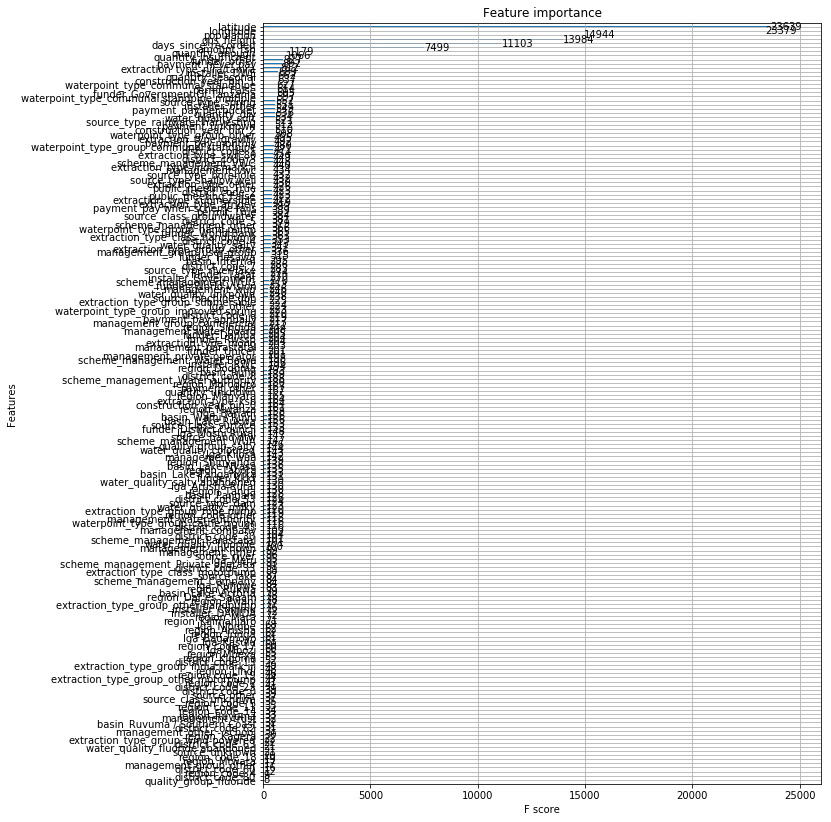

In [444]:
plot_features(xgb_model, (10,14))

In [445]:
# def model(X_train, X_test, y_train, y_test):
#     if __name__ == '__main__':
    
#         param_grid = {'learning_rate': [0.075, 0.05, 0.025],
#                       'max_depth': [4, 6, 8],
#                       'min_samples_leaf': [15, 16],
#                       'subsample': [0.8, 0.9, 1],
#                       'max_features': [1.0],
#                       'n_estimators': [1000, 500, 100],
#                       'gamma':[0,1,5]}                      

#         estimator = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", random_state=42),
#                                  param_grid=param_grid,
#                                  n_jobs=-1)

#         estimator.fit(X_train, y_train)

#         best_params = estimator.best_params_

#         print (best_params)
                                 
#         validation_accuracy = estimator.score(X_test, y_test)
#         print('Validation accuracy: ', validation_accuracy)

In [446]:
# def model(X_train, X_test, y_train, y_test):
#     if __name__ == '__main__':
    
#         param_grid = {'learning_rate': [0.075],
#                       'max_depth': [8],
#                       'min_samples_leaf': [16],
#                       'subsample': [0.8],
#                       'max_features': [1.0],
#                       'n_estimators': [1000],
#                       'gamma':[1]}                      

#         estimator = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", random_state=42),
#                                  param_grid=param_grid,
#                                  n_jobs=-1)

#         estimator.fit(X_train, y_train)

#         best_params = estimator.best_params_

#         print (best_params)
                                 
#         validation_accuracy = estimator.score(X_test, y_test)
#         print('Validation accuracy: ', validation_accuracy)

In [447]:
model(X_train, X_test, y_train, y_test)

NameError: name 'model' is not defined

In [ ]:
# def model_for_submission(features, target, test):
#     if __name__ == '__main__':

#          best_params = {'learning_rate': [0.075],
#                         'max_depth': [14],
#                         'min_samples_leaf': [16],
#                         'max_features': [1.0],
#                         'n_estimators': [100]}                      

#          estimator = GridSearchCV(estimator=GradientBoostingClassifier(),
#                                  param_grid=best_params,
#                                  n_jobs=-1)

#          estimator.fit(features, target)     

#          predictions = estimator.predict(test)

#          data = {'ID': test_id, 'status_group': predictions}

#          submit = pd.DataFrame(data=data)

#          vals_to_replace = {1:'functional', 2:'functional needs repair',
#                            3:'non functional'}

#          submit.status_group = submit.status_group.replace(vals_to_replace)        

#          submit.to_csv('pump_predictions.csv', index=False)

In [448]:
def submission(model):    

         predictions = model.predict(test_set)

         data = {'ID': test_id, 'status_group': predictions}

         submit = pd.DataFrame(data=data)

         vals_to_replace = {1:'functional',2:'non functional',3:'functional needs repair'}

         submit.status_group = submit.status_group.replace(vals_to_replace)        

         submit.to_csv('pump_predictions.csv', index=False)

In [450]:
submission(xgb_model)

In [ ]:
# Recursive Feature Elimination

rfe = RFE(rf)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

In [ ]:
#make a function out of normalizing
X_train_after_rfe = X_train.iloc[:,fit.support_].copy()
X_train_after_rfe.head()

In [ ]:
#transform target variable into categorical value

In [ ]:
#Does performing PCA make sense?